In [1]:
import os
import numpy as np
from scipy.ndimage import distance_transform_edt
from edit_annotation_tiles import edit_annotations_tiles
from load_annotation_data import load_annotation_data
from PIL import Image
from skimage.morphology import disk, dilation
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

In [2]:
# Pre - inputs
pth = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model'
pthDL = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\04_19_2024'
pthim_ann = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\5x'
classcheck = 0
datafile = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\04_19_2024\net.pkl'

In [3]:
# Inputs 
import pickle
with open(datafile, 'rb') as f:
    data = pickle.load(f)
nblack = data['nblack']
sxy = data['sxy']
ctlist0, numann0 = load_annotation_data(pthDL, pth, pthim_ann,classcheck)
numann0 = np.array(numann0)  # Convert numann0 to a NumPy array

numann = numann0.copy()
percann = np.double(numann0 > 0)
percann = np.dstack((percann, percann))
percann0 = percann.copy()
stile = None 
nbg = None

outpth = r'training'


 
Importing annotation data...
Image 1 of 2: SG_013_0061
 annotation data previously loaded
Image 2 of 2: SG_014_0016
 annotation data previously loaded


In [4]:
if nbg is None:
        nbg = 0
if stile is None:
    stile = 10000
stile += 200
kpall = 1


In [5]:
# Define folder locations
outpthim = os.path.join(pthDL, outpth, 'im/')
outpthlabel = os.path.join(pthDL, outpth, 'label/')
outpthbg = os.path.join(pthDL, outpth, 'big_tiles/')
os.makedirs(outpthim, exist_ok=True)
os.makedirs(outpthlabel, exist_ok=True)
os.makedirs(outpthbg, exist_ok=True)

In [6]:
imlistck = [f for f in os.listdir(outpthim) if f.endswith('.tif')]
nm0 = len(imlistck) + 1

In [7]:
# Create very large blank images - NO IDEA WHAT THESE VARIABLES ARE
imH = np.full((stile, stile, 3), nbg, dtype=np.double) #create an array with the specified dimensions with the value of ngb
imT = np.zeros((stile, stile)) #blank mask
nL = imT.size # size of the big tile
ct = np.zeros(numann.shape[1]) # list (size of how many annotations you have)
sf = np.sum(ct) / nL # how full is the big tile

In [8]:
count = 1
tcount = 0 #is not one because of python indexing starts at 0
cutoff = 0.55 # Cut off for how full the big tile is (55% full)
rsf = 5
type0 = 1
h = np.ones((51, 51))
h[25, 25] = 0
h = distance_transform_edt(h) < 26

In [9]:
#__________ This should be the iteration of a  while loop__________
# choose one of each class in order in a loop
if count % 10 == 1:
    type_ = tcount
    tcount = (tcount % len(ct)) + 1
# choose a tile containing the least prevalent class
else:
    tmp = np.sum(ct, axis=1)
    tmp[type0] = np.max(tmp) #
    type_ = np.argmin(tmp)
    
num = np.where(numann[:, type_] > 0)[0]

if len(num) == 0:
    numann[:, type_] = numann0[:, type_]
    num = np.where(numann[:, type_] > 0)[0]
num = np.random.choice(num, size=1, replace=False)


In [10]:
# load annotation and mask
# tile_name = ctlist0['tile_name'][num[0]] USE THIS LINE IN THE FUNCTION, FOR REPRODUCIBILITY WE WILL USE A FIXED TILE NAME
tile_name = '00226.tif' #--> 00068.tif datafile in matlab
print(tile_name)
tile_path = os.path.join(ctlist0['tile_pth'][num[0]], tile_name)
pf = tile_path.rfind('\\', 0 ,tile_path.rfind('\\'))
pthlabel = os.path.join(tile_path[0:pf], 'label')
print(pthlabel)

00226.tif
\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\data\SG_014_0016\04_19_2024_boundbox\label


In [11]:
im = np.array(Image.open(tile_path))
TA = np.array(Image.open(os.path.join(pthlabel, tile_name)))

Text(0.5, 1.0, '00226.tif pre augmentation')

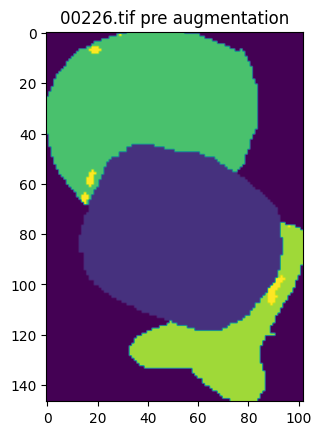

In [12]:
plt.imshow(TA)
plt.title(tile_name + ' pre augmentation')

In [13]:
doaug = (count % 3 == 1)
im, TA, kp = edit_annotations_tiles(im, TA, doaug, type_, ct, imT.shape[0], kpall) # BUUUUUUG!!!!: after the augmentation the image is not displayed correctly, some part of the images are cropped cause the frame is not adjusted correctly 
numann[num, kp-1] = 0 #kp-1 due to layer index starting in 1 and python index starting in 0
percann[num, kp-1, 0] += 1
percann[num, kp-1, 1] = 2
fx = (TA != 0)
if np.sum(fx) < 30:
    print('skipped')
    #continue

Text(0.5, 1.0, '00226.tif post augmentation')

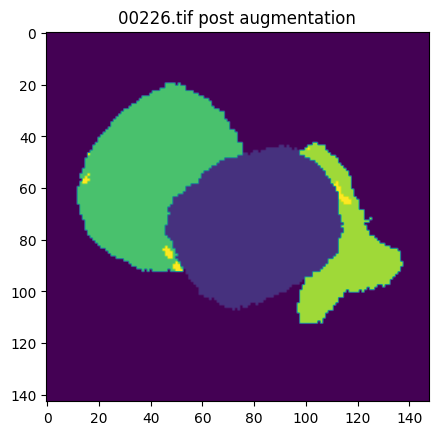

In [14]:
plt.imshow(TA) # checked jaime's code in here!!!!
plt.title(tile_name + ' post augmentation')

In [57]:
 # find low density location in large tile to add annotation
tmp = imT > 0
tmp2 = tmp[::rsf, ::rsf]
tmp2 = convolve(tmp2.astype(float), h, mode='constant', cval=0.0)
tmp = distance_transform_edt(tmp2 == 0)
tmp[:19, :] = 0
tmp[-20:, :] = 0
tmp[:, :19] = 0
tmp[:, -20:] = 0
xii = np.argmax(tmp)
xii = np.random.choice(xii, size=1, replace=False)
x, y = np.unravel_index(xii, tmp.shape)
x *= rsf
y *= rsf
szz = np.array(TA.shape) - 1
szzA = szz // 2
szzB = szz - szzA

In [8]:
%reset

In [109]:
with open(datafile, 'rb') as f:
    data = pickle.load(f)
pth = data['pthim']
print(pth)

\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\5x


In [11]:
%reset